Copyright (c) 2017, Johannes Schöneberg. All rights reserved.
The default copyright laws apply.

In [13]:
%matplotlib inline

#http://www.lighthacking.nl/nd2reader/tutorial.html
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd


import skimage
import json

#own modules / functions
import sys
pythonPackagePath = "/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis/"
sys.path.append(pythonPackagePath+"/modules")
import InputProcessing as inproc
import ForceFileProcessing as ffp

In [16]:
path = '/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12/'

inputParameters = pd.read_csv(path+'_info.csv',names=['key','value'])

inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")


inputParameters[0:5]

,key,value
0,input_data_folder,./
1,output_data_folder,./
2,vesicleID_of_that_day,v12
3,date,2018-07-13
4,movie_originalFilename,v12b2.nd2


In [17]:

date = inproc.getInputParameter(inputParameters,"date")
vesicleId = inproc.getInputParameter(inputParameters,"vesicleID_of_that_day")
movie_originalFilename = inproc.getInputParameter(inputParameters,"movie_originalFilename")

moviePath = '/Volumes/Samsung_T3b/science/confleezers/'+date+'/'+movie_originalFilename
outputPathForIndividualChannels = '/Volumes/Samsung_T3b/science/confleezers/'+date+'/'+vesicleId+'/'


#moviePath = '/Users/johannesschoeneberg/Desktop/PostDoc/hurley_lab/pulling_confleezers_dataSharing_local/2018-06-05_movie1/movie_raw.nd2'
#outputPathForIndividualChannels = '/Users/johannesschoeneberg/Desktop/PostDoc/hurley_lab/pulling_confleezers_dataSharing_local/2018-06-05_movie1/'

movie =  ND2Reader(moviePath)
print(movie)

#print(movie.metadata['width'])
#print(movie.metadata['height'])
print(movie.metadata['date'])
#print(movie.metadata['fields_of_view'])
#print(movie.metadata['frames'])
#print(movie.metadata['z_levels'])
#print(movie.metadata['total_images_per_channel'])
#print(movie.metadata['channels'])
print('px to microns %f px/µm' %(movie.metadata['pixel_microns']))
#print(movie.metadata['rois'])
print(movie.metadata['experiment'])


# write the movie date to the _info.csv
row = inputParameters.loc[inputParameters['key'] == 'movie_startTime']
inputParameters.loc[row.index,'value'] = movie.metadata['date']
print(inputParameters.loc[inputParameters['key'] == 'movie_startTime'])
inputParameters.to_csv(path+'_info.csv',index=False,header=False)

<FramesSequenceND>
Axes: 4
Axis 'x' size: 512
Axis 'y' size: 512
Axis 'c' size: 4
Axis 't' size: 331
Pixel Datatype: <class 'numpy.float64'>
2018-07-13 19:09:49
px to microns 0.051790 px/µm
{'description': 'ND Acquisition', 'loops': [{'start': 0, 'duration': 3540000.0, 'stimulation': False, 'sampling_interval': 60000.0}, {'start': 3540000.0, 'duration': 60000.0, 'stimulation': False, 'sampling_interval': 60000.0}, {'start': 3600000.0, 'duration': 900000.0, 'stimulation': False, 'sampling_interval': 1.0}]}
               key                value
6  movie_startTime  2018-07-13 19:09:49


# look at the first movie frame

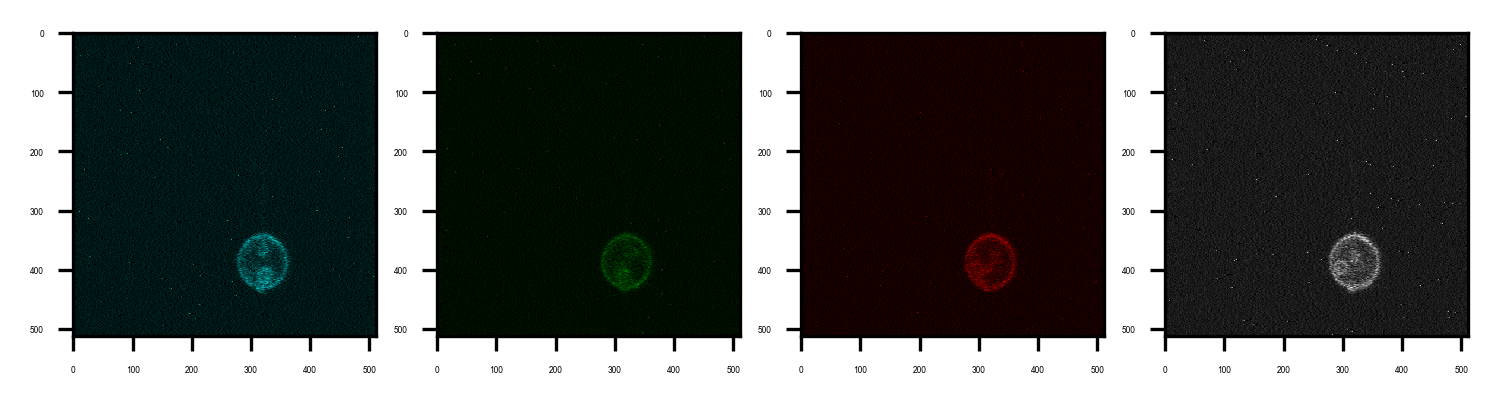

In [18]:




cmap_ch0 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","cyan"])
cmap_ch1= matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
cmap_ch2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
cmap_ch3= matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","white"])

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 2}

matplotlib.rc('font', **font)

plt.figure(dpi=300)

# sp1
plt.subplot(141)
plt.imshow(movie[0],cmap=cmap_ch0)

# sp1
plt.subplot(142)
plt.imshow(movie[1],cmap=cmap_ch1)

# sp1
plt.subplot(143)
plt.imshow(movie[2],cmap=cmap_ch2)

# sp1
plt.subplot(144)
plt.imshow(movie[3],cmap=cmap_ch3)


# Crop the movie according to Fiji (test there what looks good, then implement it here)



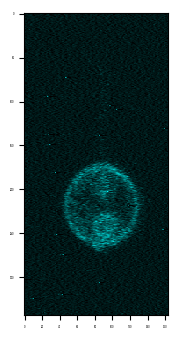

In [19]:
crop_xStart = int(inproc.getInputParameter(inputParameters,"movie_crop_xStart"))
crop_xWidth = int(inproc.getInputParameter(inputParameters,"movie_crop_xwidth"))
crop_yStart = int(inproc.getInputParameter(inputParameters,"movie_crop_yStart"))
crop_yHeight = int(inproc.getInputParameter(inputParameters,"movie_crop_yheight"))
plt.figure(dpi=100)
plt.imshow(movie[0][crop_yStart:crop_yStart+crop_yHeight,crop_xStart:crop_xStart+crop_xWidth],cmap=cmap_ch0)

In [20]:
averaging = True
winsize = 20

for i in range(movie.sizes['c']):
    # do the  channels individually (otherwise it might blow out your RAM)

    channelID = i

    movie_ch = []
    movie.default_coords['c'] = channelID
    movie.iter_axes = 't'
    for t in range(0,movie.sizes['t']):
        movie_ch.append(movie[t][crop_yStart:crop_yStart+crop_yHeight,crop_xStart:crop_xStart+crop_xWidth])
    
    movie_ch = np.array(movie_ch)
    data = movie_ch.astype('uint16')
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    print(data.shape, data.dtype, metadata['microscope'])
    metadata = json.dumps(metadata)
    print(metadata)

    outputPath = outputPathForIndividualChannels+'/movie_ch'+str(channelID)+'.tif'
    print(outputPath)
    skimage.external.tifffile.imsave(outputPath, data, description=metadata)
    
    if(averaging):
        mvgAvgInput = movie_ch
        movie_ch_moveAvg = []
        for i in range (0,len(mvgAvgInput)-winsize):
            movie_ch_moveAvg.append(np.average(mvgAvgInput[i:i+winsize],axis=0))
        
        movie_ch_moveAvg = np.array(movie_ch_moveAvg)
        data = movie_ch_moveAvg.astype('uint16')
        metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
        print(data.shape, data.dtype, metadata['microscope'])
        metadata = json.dumps(metadata)
        print(metadata)
    
        outputPath = outputPathForIndividualChannels+'/movie_ch'+str(channelID)+'_avg'+str(winsize)+'.tif'
        print(outputPath)
        skimage.external.tifffile.imsave(outputPath, data, description=metadata)    

(331, 344, 164) uint16 joh
{"microscope": "joh", "shape": [331, 344, 164], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12//movie_ch0.tif
(311, 344, 164) uint16 joh
{"microscope": "joh", "shape": [311, 344, 164], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12//movie_ch0_avg20.tif
(331, 344, 164) uint16 joh
{"microscope": "joh", "shape": [331, 344, 164], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12//movie_ch1.tif
(311, 344, 164) uint16 joh
{"microscope": "joh", "shape": [311, 344, 164], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12//movie_ch1_avg20.tif
(331, 344, 164) uint16 joh
{"microscope": "joh", "shape": [331, 344, 164], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12//movie_ch2.tif
(311, 344, 164) uint16 joh
{"microscope": "joh", "shape": [311, 344, 164], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12//movie_ch2_avg20.tif
(331, 344,

# No Cropping: split the movie into 4 individual tiff channels, and save the 20 win average as well


In [11]:
averaging = True
winsize = 20

for i in range(movie.sizes['c']):
    # do the  channels individually (otherwise it might blow out your RAM)

    channelID = i

    movie_ch = []
    movie.default_coords['c'] = channelID
    movie.iter_axes = 't'
    for t in range(0,movie.sizes['t']):
        movie_ch.append(movie[t][])
    
    movie_ch = np.array(movie_ch)
    data = movie_ch.astype('uint16')
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    print(data.shape, data.dtype, metadata['microscope'])
    metadata = json.dumps(metadata)
    print(metadata)

    outputPath = outputPathForIndividualChannels+'/movie_ch'+str(channelID)+'.tif'
    print(outputPath)
    skimage.external.tifffile.imsave(outputPath, data, description=metadata)
    
    if(averaging):
        mvgAvgInput = movie_ch
        movie_ch_moveAvg = []
        for i in range (0,len(mvgAvgInput)-winsize):
            movie_ch_moveAvg.append(np.average(mvgAvgInput[i:i+winsize],axis=0))
        
        movie_ch_moveAvg = np.array(movie_ch_moveAvg)
        data = movie_ch_moveAvg.astype('uint16')
        metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
        print(data.shape, data.dtype, metadata['microscope'])
        metadata = json.dumps(metadata)
        print(metadata)
    
        outputPath = outputPathForIndividualChannels+'/movie_ch'+str(channelID)+'_avg'+str(winsize)+'.tif'
        print(outputPath)
        skimage.external.tifffile.imsave(outputPath, data, description=metadata)    

(2474, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2474, 512, 512], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v24b1001_processed/movie_ch0.tif
(2454, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2454, 512, 512], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v24b1001_processed/movie_ch0_avg20.tif
(2474, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2474, 512, 512], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v24b1001_processed/movie_ch1.tif
(2454, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2454, 512, 512], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v24b1001_processed/movie_ch1_avg20.tif
(2474, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2474, 512, 512], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v24b1001_processed/movie_ch2.tif
(2454, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2454, 512, 512], "dtype": "<u2"}
/Volu

In [6]:
individualChannels = []
for ch in range(0,movie.sizes['c']):
    movie_ch = []
    movie.default_coords['c'] = ch
    movie.iter_axes = 't'
    for t in range(0,movie.sizes['t']):
        movie_ch.append(movie[t])
    individualChannels.append(np.array(movie_ch))
    

4